In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Это домашка на 5 баллов
## Остальные 5 баллов за домашку будут на word2vec (следующее занятие)

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Не стоит пока об этом задумываться, это просто нормализация для картинок

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

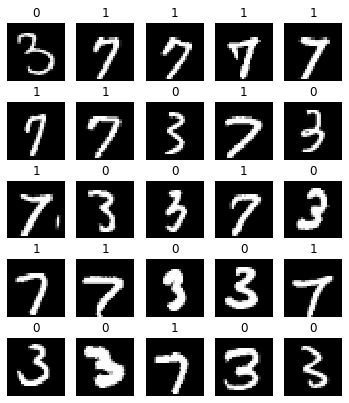

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Пояснения
### классу 0 соответствует цифра 3
### классу 1 соответствует цифра 7
#### Выбрал эти цифры, потому что на них хуже всего метрики

# Итерация по датасету
# А вот сюда стоит обратить внимание

In [7]:
for x, y in train_loader:
    break

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [8]:
x.shape

torch.Size([128, 1, 28, 28])

## Просто выпрямим нашу матрицу в один вектор
### Для нашей игрушечной задачи для поучиться будет достаточно

In [9]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

In [10]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [11]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [12]:
x.shape

(128, 784)

# Наши бинарные таргеты

In [13]:
y

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1])

In [14]:
# ошибка это нормально
x * y

ValueError: operands could not be broadcast together with shapes (128,784) (128,) 

In [ ]:
# давайте ее исправим

In [15]:
y = np.expand_dims(y, 1)

In [20]:
x * y

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]])

In [17]:
# исправили

# Итерация по эпохам

In [18]:
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными, например, учить, но пока этого делать не будет
        
        time.sleep(0.05)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Давайте поучим пока не очень красиво нашу 2-х слойную нейронку

## 3 балла

### Шаги:
0. Задайте обучаемые параметры (TIP: np.random.rand) и скорость обучения для градиентного спуска.
1. Линейная трансформация через первый слой
1. Применение какой-нибудь нелийной функции активации
1. Линейная трансформация через второй слой
1. Примените какую-нибудь функцию, которая хорошая для бинарной классификации, чтобы перейти к вероятностям классов
1. Рассчитайте функцию потерь (бинарная кросс энтропия), не забудьте усреднить по батчу
1. Возьмите производные от функции потерь к каждому обучаемому параметру [видео про производные](https://youtu.be/tZ0yCzWfbZc)
1. Обновите веса w1, b1, w2, b2 с помощью градиентного спуска
1. Сохраняйте значения функции потерь и нарисуйте ее график

- TIP: количество входных фичей - 784 (28 пикселей * 28 пикселей)
- TIP: в шаге 0 домножьте w1, w2 на 0.01, а b1, b2 инициализируйте нулями
- TIP: в backward функции потерь по предсказаниям вашей модели нужно разделить еще на количество примеров в батче
- TIP: каждый следующий градиент рассчитывайте умножая на предыдущий

## Если вам сложно, сделайте сначала для одного слоя

In [21]:
### КОД СЮДА ###
learning_rate = 0.01
epochs = 5
in_features = 784
hidden_size = 256
out_features = 1
batch_size = 128

w1 = np.random.rand(in_features, hidden_size) * 0.01
b1 = np.zeros(hidden_size)
w2 = np.random.rand(hidden_size, out_features) * 0.01
b2 = np.zeros(out_features)

def dReLU(x): # производная от ReLU
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dSigmoid(Z): # производная от сигмоиды
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        ### КОД СЮДА ###
        
        # forward
        z_1 = np.dot(x, w1) + b1
        a_1 = np.maximum(0, z_1) # ReLU
        z_2 = np.dot(a_1, w2) + b2
        pred = 1/(1+np.exp(-z_2)) # sigmoid
        
        # рассчет bce
        loss = - (y * np.log(pred) + (1-y) * np.log(1-pred))
        avg_loss = loss.mean()
        losses.append(avg_loss)
        
        # backward
        dL_pred = np.divide(1-y, 1-pred) - np.divide(y, pred)
        dL_z2 = dL_pred * dSigmoid(z_2) 
        dL_a1 = np.dot(dL_z2, w2.T) 
        dL_w2 = 1./dL_z2.shape[0] * np.dot(a_1.T, dL_z2) 
        dL_b2 = 1./dL_z2.shape[0] * np.dot(np.ones(dL_z2.shape[0]), dL_z2) 
        dL_z1 = dL_a1 * dReLU(z_1)
        dL_w1 = 1./dL_z1.shape[0] * np.dot(x.T, dL_z1) 
        dL_b1 = 1./dL_z1.shape[0] * np.dot(np.ones(dL_z1.shape[0]), dL_z1)  
        
        # gradient descent
        w1 = w1 - learning_rate * dL_w1
        b1 = b1 - learning_rate * dL_b1
        w2 = w2 - learning_rate * dL_w2
        b2 = b2 - learning_rate * dL_b2

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred - сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_loss/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- dz2/db2 - градиент линейного преобразования по b2 - (1,)
- da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

# Значение функции потерь на уровне 0.1 это уже выше 90% точности

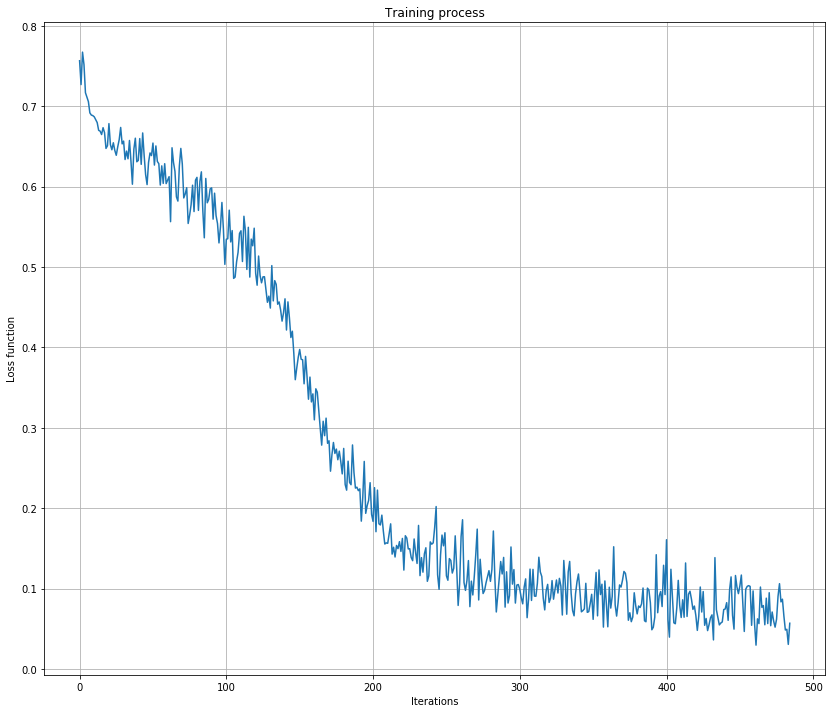

In [23]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# По крутому

## 2 балла

# Импортируем нашу библиотеку

## Реализуйте такие слои:
- Linear - линейная трансформация (не забудьте, что у нас там как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, )

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом)

In [24]:
from our_library import wrapper, tools
#from our_library.layers import Linear, ReLU, BCELoss, Sigmoid, NeuralNetwork

In [25]:
# layers.py

import numpy as np


class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass


class ReLU:

    def __init__(self):
        self._ReLU_result = None
        self.X = None

    def forward(self, x):
        self._ReLU_result = np.maximum(0, x)
        self.X = x
        return self._ReLU_result

    def backward(self, grad):        
        new_grad = np.array([[1 if i > 0 else 0 for i in el] for el in self.X]) * grad
        return new_grad
    
    def step(self, learning_rate):

        pass
    
    
class Linear:

    def __init__(self, in_features, out_features):
        
        # инициализируем веса
        self.weight = np.random.rand(in_features, out_features) * 0.01
        self.bias = np.zeros(out_features,) * 0.01
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None

        self.X = None
        

    def forward(self, x):

        self.X = x
        self._linear_result = np.dot(x, self.weight) + self.bias
        return self._linear_result

    def backward(self, grad):
        
        linear_grad = np.dot(grad, self.weight.T) 
        
        self._grad_weight = np.dot(self.X.T, grad) / grad.shape[0] 
        self._grad_bias = np.dot(np.ones(grad.shape[0]), grad) / grad.shape[0]
        
        return linear_grad 

    def step(self, learning_rate):
        self.weight = self.weight - learning_rate * self._grad_weight
        self.bias = self.bias - learning_rate * self._grad_bias
    
    
class BCELoss:

    def __init__(self):
        self.real = None
        self.pred = None
        self.loss = None

    def forward(self, x, y):
        self.real = np.expand_dims(y, 1)
        self.pred = x
        loss = - (self.real * np.log(self.pred) + (1-self.real) * np.log(1-self.pred))
        self.loss = loss.mean()
        return self.loss

    def backward(self):
        loss_grad = np.divide((1-self.real), (1-self.pred)) - np.divide(self.real, self.pred)
        return loss_grad

    def step(self, learning_rate):
        pass

    
    
# модель
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules

    def forward(self, x):
        cur_x = x # текущее состояние x
        for layer in self.modules:
            cur_x = layer.forward(cur_x)
        return cur_x
            
    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        cur_grad = grad
        for layer in self.modules[::-1]:
            cur_grad = layer.backward(cur_grad)

    def step(self, learning_rate): 
        for layer in self.modules:
            layer.step(learning_rate)
    
    
    

class NLLLoss:

    def __init__(self):

        self._softmax_result = None
        self._y = None

    @staticmethod
    def softmax(x, axis=1):

        exp_scores = np.exp(x)

        return exp_scores / exp_scores.sum(axis, keepdims=True)

    def forward(self, x, y):

        self._softmax_result = self.softmax(x)

        self._y = np.zeros_like(x)
        self._y[np.arange(x.shape[0]), y] = 1

        loss = - (np.log(self._softmax_result) * self._y).sum(1).mean()

        return loss

    def backward(self):

        return (self._softmax_result - self._y) / self._y.shape[0]

    def step(self, learning_rate):

        pass



# Пример, который мы разбирали в [видео про производные](https://youtu.be/tZ0yCzWfbZc)

In [26]:
class Sigmoid:

    def __init__(self):
        self._sigmoid_result = None

    def forward(self, x):
        self._sigmoid_result = 1 / (1 + np.exp(-x))
        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """
        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad
        return new_grad

    def step(self, learning_step):
        
        pass

# Пример работы тестов

In [27]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

In [28]:
sigmoid_layer = Sigmoid()

In [29]:
forward_result = sigmoid_layer.forward(x)

In [30]:
correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

In [31]:
# Must be close to zero
# -3.8713787731126104e-10
(correct_forward_result - forward_result).sum()

-3.8713787731126104e-10

In [32]:
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [33]:
correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [34]:
# Must be close to zero
# -1.7161740806237447e-08
(correct_backward_result - backward_result).sum()

-1.7161740806237447e-08

# Linear test

In [35]:
linear = Linear(in_features=4, out_features=3)

In [36]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [37]:
linear.weight

array([[0.00879391, 0.0075844 , 0.00430709],
       [0.00884834, 0.00921104, 0.00044317],
       [0.00011441, 0.00822498, 0.00122346],
       [0.00338301, 0.0001627 , 0.00711473]])

In [38]:
linear.bias

array([0., 0., 0.])

In [39]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

In [40]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

In [41]:
forward = linear.forward(x)

In [42]:
# Must be close to zero
# -1.2008401972449234e-09
(correct_forward_result - forward).sum()

-1.2008401972449234e-09

In [43]:
previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ], # batch_size = 2, out_features = 3
                          [0.73044998, 0.18287682, 0.41246361]])

In [44]:
correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307], # batch_size, in_features
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

In [45]:
backward = linear.backward(previous_grad)

In [46]:
print(backward)

[[0.01089683 0.00842654 0.00822628 0.00729307]
 [0.00958704 0.00833055 0.00209236 0.00543544]]


In [47]:
# Must be close to zero
# 4.610488500960547e-09
(correct_backward_result - backward).sum()

4.610488500960547e-09

In [48]:
correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165], # 4 * 3
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

In [49]:
print(linear._grad_weight)

[[0.30359787 0.46395161 0.62415083]
 [0.04484162 0.07510107 0.09986047]
 [0.11444837 0.35551929 0.44606907]
 [0.07437316 0.27012284 0.33549304]]


In [50]:
# Must be close to zero
# 2.0459672428474462e-09
(linear._grad_weight - correct_grad_weight).sum()

-3.207529233977016

In [51]:
correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [52]:
# Must be close to zero
# -2.220446049250313e-16
(linear._grad_bias - correct_grad_bias).sum()

-1.5956192050000002

# ReLU test

In [53]:
relu = ReLU()

In [54]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

In [55]:
forward = relu.forward(x)

In [56]:
correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

In [57]:
# Must be close to zero
# 0.0
(forward - correct_forward_result).sum()

0.0

In [58]:
previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

In [59]:
correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [60]:
backward = relu.backward(previous_grad)

In [61]:
# Must be close to zero
# 0.0
(correct_backward_result - backward).sum()

0.0

# BCE test

In [62]:
loss = BCELoss()

In [63]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

In [64]:
forward = loss.forward(x, y)

In [65]:
print(forward)

0.24384403491500606


In [66]:
correct_forward_result = 0.24384403491500606

In [67]:
# Must be close to zero
# 0.0
(forward - correct_forward_result).sum()

0.0

In [68]:
backward = loss.backward()

In [69]:
print(backward)

[[-1.31160774]
 [ 1.09991786]
 [-1.66177424]
 [ 1.10627788]]


In [70]:
correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [71]:
# Must be close to zero
# 1.051905440530021e-08
(backward - correct_backward_result).sum()

-0.5753896679237823

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: циклы это круто
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward
- TIP 5: forward и backward ничего не должны отдавать
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

## Реализуйте обертку над моделью

In [74]:
class MNISTWrapper(wrapper.Wrapper):

    def __init__(self, model, loss, learning_rate=0.001, multi_class=False):

        # передаем параметры, чтобы отработал __init__ от наследуемого класса
        # можно было бы сделать через **kwargs, но сделал так для наглядности и чтобы были подсказки в юпитере

        super().__init__(model=model, loss=loss, learning_rate=learning_rate, multi_class=multi_class)

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
        prediction = self.model.forward(x)#1
        loss_batch = self.loss.forward(prediction, y)#2
        loss_batch_grad = self.loss.backward()#3
        self.model.backward(loss_batch_grad)#4
        self.model.step(self.learning_rate)#5
        
        return loss_batch, prediction
        
        
    def predict_batch(self, x):
        """
        Предсказание (aka inference) вашей модели:
        1. Рассчет forward
        :param x: входные данные np.array with shape (batch_size, n_features)
        :return: prediction - матрица предсказаний вашей модели
        """        
        # Больше ничего делать не нужно
        # Все уже сделано
        
        return self.model.forward(x)

In [79]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 5

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = NeuralNetwork([Linear(784, 256), ReLU(), Linear(256,1), Sigmoid()])

loss = BCELoss()

In [80]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

## Раскомментируйте и запустите

In [81]:
classifier.train(train_loader, test_loader, epochs=epochs)

Epoch 5: 100%|██████████| 12396/12396 [00:06<00:00, 2049.95it/s, loss=0.0757, metric=0.977]


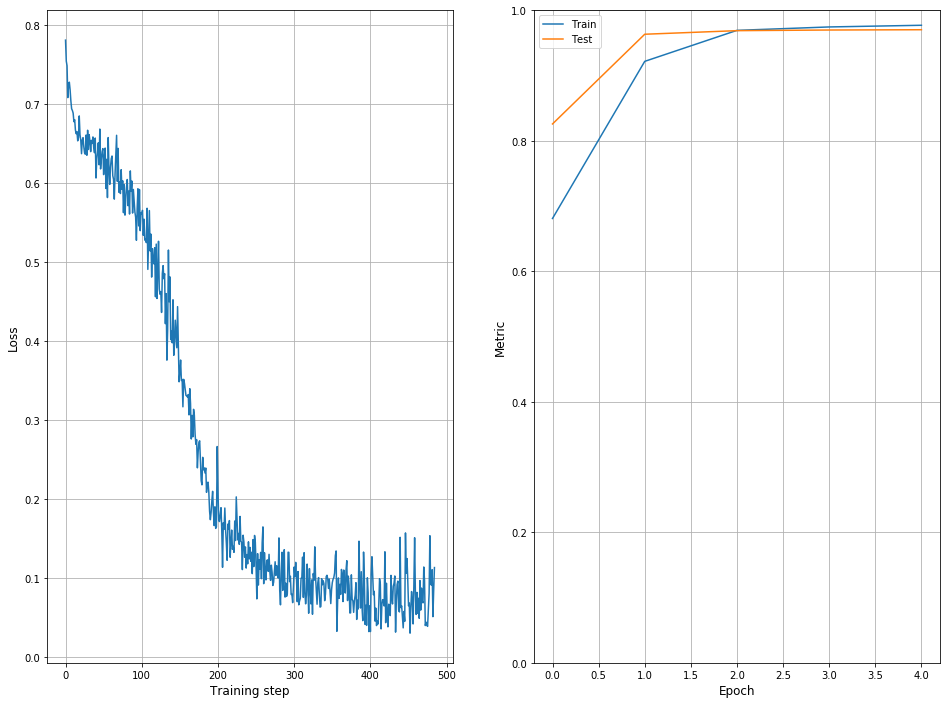

In [82]:
classifier.plot()

# Немного торча

In [112]:
import torch

### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе

In [113]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

Sequential(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Либо так

In [114]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
  (3): Sigmoid()
)

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [115]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):
    
    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # 
    # передаем ссылку на самого себя первым параметром
    # 
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    # 
    def __init__(self, in_features, inner_features, out_features):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()
        
    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):
        
        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)
        
        return x
    
    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [116]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)

In [117]:
model

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [118]:
# можем посмотреть веса
model.linear_1.weight.shape

torch.Size([256, 784])

In [119]:
# еще нам нужно задать функцию потерь 
criterion = torch.nn.BCELoss()

In [120]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [121]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[ 0.0147, -0.0304, -0.0167,  ..., -0.0072,  0.0306,  0.0085],
         [-0.0232, -0.0244, -0.0129,  ...,  0.0294,  0.0267, -0.0091],
         [-0.0175,  0.0261, -0.0131,  ...,  0.0020, -0.0005, -0.0273],
         ...,
         [ 0.0196, -0.0169, -0.0327,  ...,  0.0162,  0.0241,  0.0235],
         [-0.0221,  0.0257, -0.0155,  ..., -0.0230, -0.0207,  0.0151],
         [ 0.0211, -0.0286, -0.0095,  ..., -0.0133, -0.0296,  0.0353]],
        requires_grad=True), Parameter containing:
 tensor([-0.0136, -0.0024, -0.0179,  0.0270,  0.0144,  0.0335,  0.0090, -0.0077,
         -0.0262,  0.0115, -0.0002, -0.0115,  0.0161,  0.0294,  0.0221, -0.0063,
         -0.0205,  0.0020,  0.0287,  0.0322,  0.0323,  0.0200,  0.0225, -0.0031,
          0.0005, -0.0136,  0.0092, -0.0286,  0.0269,  0.0162, -0.0239, -0.0045,
          0.0063,  0.0070,  0.0016,  0.0171, -0.0279, -0.0003,  0.0140, -0.0240,
         -0.0093,  0.0165,  0.0305,  0.0304, -0.0242,  0.0186,  0.0183,  0.0160,

# Обучим нашу модель

In [122]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука все еще отдает нам батчи данных
# мы поговорим про нее позже
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
    # 
    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч
    # 
    optimizer.zero_grad()
    
    # 
    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    # 
    # торч строит динамический граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    # 
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили релу
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation
    # 
    pred = model(x)
    
    # 
    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    # 
    loss = criterion(pred, y.float())
    
    # 
    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    # 
    # то есть это почти то же самое, что мы делали в домашке с классами
    # 
    loss.backward()
    
    # 
    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    # 
    optimizer.step()
    
    # 
    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    # 
    # для тензоров работает метод .tolist()
    # 
    current_loss_value = loss.item()
    losses.append(loss.item())

In [123]:
# Одна эпоха прошла

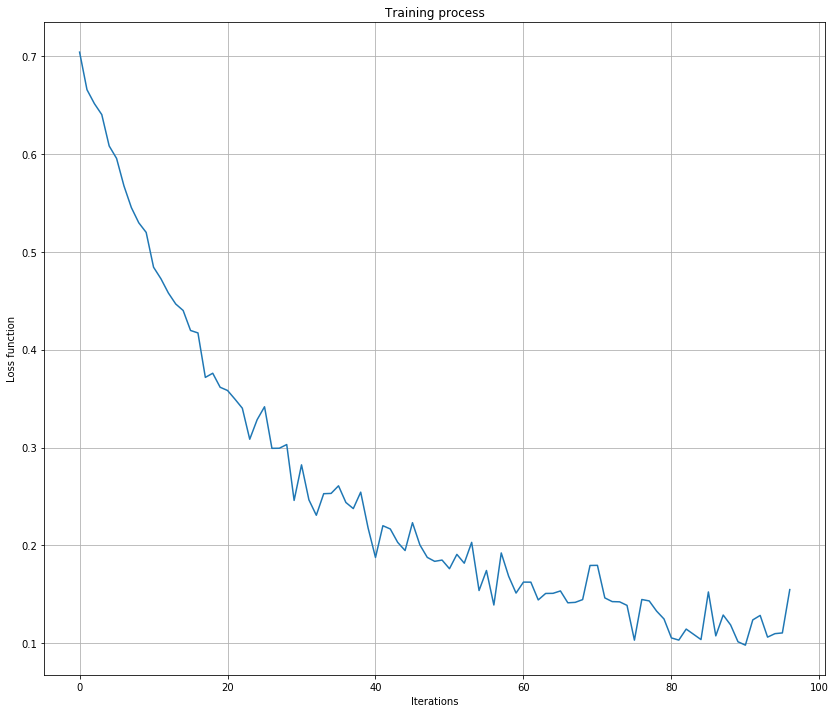

In [124]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Теперь мы можем что-то предсказать

In [125]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [126]:
x.shape

torch.Size([128, 784])

In [127]:
y.shape

torch.Size([128, 1])

In [128]:
# переходим в режим предсказания
# 
# позже в курсе мы разберем зачем конкретно это нужно
# 
# для искушенного нетерпеливого читателя: дропаут больше не дропаутит, батч норм больше не нормирует каждый батч
# а использует накопленную статистику при обучении и тд
# 
model.eval()

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [129]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
with torch.no_grad():

    pred = model(x)

In [130]:
pred.shape

torch.Size([128, 1])

In [131]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [132]:
pred.shape

torch.Size([128])

In [134]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [135]:
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [136]:
type(y)

numpy.ndarray

In [137]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [138]:
# посчитаем метрику на батче
accuracy_score(y, pred)

0.96875

In [139]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [161]:
len(train_loader.dataset)

12396

In [140]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    # как раз early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    # пожалуй, самый популярный метод валидации для нейронных сетей
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break    









Epoch 1:   0%|          | 0/12396 [00:00<?, ?it/s]







Epoch 1:   0%|          | 0/12396 [00:00<?, ?it/s, train_loss=0.673]







Epoch 1:   1%|          | 128/12396 [00:00<00:08, 1511.91it/s, train_loss=0.544]







Epoch 1:   2%|▏         | 256/12396 [00:00<00:06, 2008.97it/s, train_loss=0.448]







Epoch 1:   3%|▎         | 384/12396 [00:00<00:04, 2910.66it/s, train_loss=0.448]







Epoch 1:   3%|▎         | 384/12396 [00:00<00:04, 2910.66it/s, train_loss=0.384]







Epoch 1:   4%|▍         | 512/12396 [00:00<00:04, 2910.66it/s, train_loss=0.329]







Epoch 1:   5%|▌         | 640/12396 [00:00<00:04, 2910.66it/s, train_loss=0.291]







Epoch 1:   6%|▌         | 768/12396 [00:00<00:03, 2920.68it/s, train_loss=0.291]







Epoch 1:   6%|▌         | 768/12396 [00:00<00:03, 2920.68it/s, train_loss=0.261]







Epoch 1:   7%|▋         | 896/12396 [00:00<00:03, 2920.68it/s, train_loss=0.247]







Epoch 1:   8%|▊         | 1024/12396 [00:00<00:04, 2627.01it/s, tr

Epoch 1:  55%|█████▍    | 6784/12396 [00:02<00:02, 2521.28it/s, train_loss=0.084] 







Epoch 1:  56%|█████▌    | 6912/12396 [00:02<00:02, 2521.28it/s, train_loss=0.0832]







Epoch 1:  57%|█████▋    | 7040/12396 [00:02<00:01, 2690.31it/s, train_loss=0.0832]







Epoch 1:  57%|█████▋    | 7040/12396 [00:02<00:01, 2690.31it/s, train_loss=0.082] 







Epoch 1:  58%|█████▊    | 7168/12396 [00:02<00:01, 2690.31it/s, train_loss=0.0816]







Epoch 1:  59%|█████▉    | 7296/12396 [00:02<00:01, 2690.31it/s, train_loss=0.0809]







Epoch 1:  60%|█████▉    | 7424/12396 [00:02<00:01, 2612.88it/s, train_loss=0.0809]







Epoch 1:  60%|█████▉    | 7424/12396 [00:02<00:01, 2612.88it/s, train_loss=0.0813]







Epoch 1:  61%|██████    | 7552/12396 [00:02<00:01, 2612.88it/s, train_loss=0.0821]







Epoch 1:  62%|██████▏   | 7680/12396 [00:02<00:01, 2612.88it/s, train_loss=0.0813]







Epoch 1:  63%|██████▎   | 7808/12396 [00:02<00:01, 2558.54it/s, train_loss=0.0813]







Epoch 1:  

Losses: train - 0.064, test = 0.043
Test: accuracy - 0.987










Epoch 2:   4%|▍         | 512/12396 [00:00<00:03, 3049.14it/s, train_loss=0.0524]







Epoch 2:   5%|▌         | 640/12396 [00:00<00:03, 3049.14it/s, train_loss=0.0501]







Epoch 2:   6%|▌         | 768/12396 [00:00<00:03, 2958.21it/s, train_loss=0.0501]







Epoch 2:   6%|▌         | 768/12396 [00:00<00:03, 2958.21it/s, train_loss=0.0488]







Epoch 2:   7%|▋         | 896/12396 [00:00<00:03, 2958.21it/s, train_loss=0.0478]







Epoch 2:   8%|▊         | 1024/12396 [00:00<00:03, 2958.21it/s, train_loss=0.0469]







Epoch 2:   9%|▉         | 1152/12396 [00:00<00:03, 2926.67it/s, train_loss=0.0469]







Epoch 2:   9%|▉         | 1152/12396 [00:00<00:03, 2926.67it/s, train_loss=0.0461]







Epoch 2:  10%|█         | 1280/12396 [00:00<00:03, 2926.67it/s, train_loss=0.0448]







Epoch 2:  11%|█▏        | 1408/12396 [00:00<00:03, 2773.38it/s, train_loss=0.0448]







Epoch 2:  11%|█▏        | 1408/12396 [00:00<00:03, 2773.38it/s, train_loss=0.044] 







Epoch 2

Epoch 2:  58%|█████▊    | 7168/12396 [00:02<00:01, 2696.64it/s, train_loss=0.0336]







Epoch 2:  58%|█████▊    | 7168/12396 [00:02<00:01, 2696.64it/s, train_loss=0.0334]







Epoch 2:  59%|█████▉    | 7296/12396 [00:02<00:01, 2696.64it/s, train_loss=0.0331]







Epoch 2:  60%|█████▉    | 7424/12396 [00:02<00:01, 2696.64it/s, train_loss=0.033] 







Epoch 2:  61%|██████    | 7552/12396 [00:02<00:01, 2810.72it/s, train_loss=0.033]







Epoch 2:  61%|██████    | 7552/12396 [00:02<00:01, 2810.72it/s, train_loss=0.0327]







Epoch 2:  62%|██████▏   | 7680/12396 [00:02<00:01, 2810.72it/s, train_loss=0.0326]







Epoch 2:  63%|██████▎   | 7808/12396 [00:02<00:01, 2810.72it/s, train_loss=0.032] 







Epoch 2:  64%|██████▍   | 7936/12396 [00:02<00:01, 2814.18it/s, train_loss=0.032]







Epoch 2:  64%|██████▍   | 7936/12396 [00:03<00:01, 2814.18it/s, train_loss=0.0309]







Epoch 2:  65%|██████▌   | 8064/12396 [00:03<00:01, 2814.18it/s, train_loss=0.0309]







Epoch 2:  66

Losses: train - 0.028, test = 0.033
Test: accuracy - 0.989










Epoch 3:   4%|▍         | 512/12396 [00:00<00:04, 2733.47it/s, train_loss=0.0274]







Epoch 3:   5%|▌         | 640/12396 [00:00<00:04, 2733.47it/s, train_loss=0.0274]







Epoch 3:   6%|▌         | 768/12396 [00:00<00:04, 2777.95it/s, train_loss=0.0274]







Epoch 3:   6%|▌         | 768/12396 [00:00<00:04, 2777.95it/s, train_loss=0.0274]







Epoch 3:   7%|▋         | 896/12396 [00:00<00:04, 2777.95it/s, train_loss=0.0272]







Epoch 3:   8%|▊         | 1024/12396 [00:00<00:04, 2777.95it/s, train_loss=0.0269]







Epoch 3:   9%|▉         | 1152/12396 [00:00<00:04, 2718.44it/s, train_loss=0.0269]







Epoch 3:   9%|▉         | 1152/12396 [00:00<00:04, 2718.44it/s, train_loss=0.0265]







Epoch 3:  10%|█         | 1280/12396 [00:00<00:04, 2718.44it/s, train_loss=0.0266]







Epoch 3:  11%|█▏        | 1408/12396 [00:00<00:04, 2576.04it/s, train_loss=0.0266]







Epoch 3:  11%|█▏        | 1408/12396 [00:00<00:04, 2576.04it/s, train_loss=0.0266]







Epoch 3

Epoch 3:  58%|█████▊    | 7168/12396 [00:02<00:02, 2537.35it/s, train_loss=0.0219]







Epoch 3:  58%|█████▊    | 7168/12396 [00:02<00:02, 2537.35it/s, train_loss=0.0218]







Epoch 3:  59%|█████▉    | 7296/12396 [00:02<00:02, 2537.35it/s, train_loss=0.0217]







Epoch 3:  60%|█████▉    | 7424/12396 [00:02<00:01, 2537.35it/s, train_loss=0.0216]







Epoch 3:  61%|██████    | 7552/12396 [00:02<00:01, 2672.92it/s, train_loss=0.0216]







Epoch 3:  61%|██████    | 7552/12396 [00:02<00:01, 2672.92it/s, train_loss=0.0213]







Epoch 3:  62%|██████▏   | 7680/12396 [00:02<00:01, 2672.92it/s, train_loss=0.0213]







Epoch 3:  63%|██████▎   | 7808/12396 [00:03<00:01, 2672.92it/s, train_loss=0.0213]







Epoch 3:  64%|██████▍   | 7936/12396 [00:03<00:01, 2818.10it/s, train_loss=0.0213]







Epoch 3:  64%|██████▍   | 7936/12396 [00:03<00:01, 2818.10it/s, train_loss=0.0212]







Epoch 3:  65%|██████▌   | 8064/12396 [00:03<00:01, 2818.10it/s, train_loss=0.0211]







Epoch 3:  

Losses: train - 0.016, test = 0.025
Test: accuracy - 0.992










Epoch 4:   4%|▍         | 512/12396 [00:00<00:03, 3055.33it/s, train_loss=0.0159]







Epoch 4:   5%|▌         | 640/12396 [00:00<00:04, 2764.82it/s, train_loss=0.0159]







Epoch 4:   5%|▌         | 640/12396 [00:00<00:04, 2764.82it/s, train_loss=0.0159]







Epoch 4:   6%|▌         | 768/12396 [00:00<00:04, 2764.82it/s, train_loss=0.0162]







Epoch 4:   7%|▋         | 896/12396 [00:00<00:04, 2657.09it/s, train_loss=0.0162]







Epoch 4:   7%|▋         | 896/12396 [00:00<00:04, 2657.09it/s, train_loss=0.0161]







Epoch 4:   8%|▊         | 1024/12396 [00:00<00:04, 2657.09it/s, train_loss=0.016]







Epoch 4:   9%|▉         | 1152/12396 [00:00<00:04, 2559.61it/s, train_loss=0.016]







Epoch 4:   9%|▉         | 1152/12396 [00:00<00:04, 2559.61it/s, train_loss=0.0163]







Epoch 4:  10%|█         | 1280/12396 [00:00<00:04, 2559.61it/s, train_loss=0.0166]







Epoch 4:  11%|█▏        | 1408/12396 [00:00<00:04, 2559.61it/s, train_loss=0.0167]







Epoch 4:  

Epoch 4:  58%|█████▊    | 7168/12396 [00:02<00:01, 2843.04it/s, train_loss=0.0115]







Epoch 4:  59%|█████▉    | 7296/12396 [00:02<00:01, 2843.04it/s, train_loss=0.0116]







Epoch 4:  60%|█████▉    | 7424/12396 [00:02<00:01, 2843.04it/s, train_loss=0.0122]







Epoch 4:  61%|██████    | 7552/12396 [00:02<00:01, 2728.93it/s, train_loss=0.0122]







Epoch 4:  61%|██████    | 7552/12396 [00:02<00:01, 2728.93it/s, train_loss=0.0123]







Epoch 4:  62%|██████▏   | 7680/12396 [00:02<00:01, 2728.93it/s, train_loss=0.0122]







Epoch 4:  63%|██████▎   | 7808/12396 [00:02<00:01, 2728.93it/s, train_loss=0.0121]







Epoch 4:  64%|██████▍   | 7936/12396 [00:02<00:01, 2723.40it/s, train_loss=0.0121]







Epoch 4:  64%|██████▍   | 7936/12396 [00:03<00:01, 2723.40it/s, train_loss=0.0121]







Epoch 4:  65%|██████▌   | 8064/12396 [00:03<00:01, 2723.40it/s, train_loss=0.0121]







Epoch 4:  66%|██████▌   | 8192/12396 [00:03<00:01, 2723.40it/s, train_loss=0.012] 







Epoch 4:  

Losses: train - 0.010, test = 0.024
Test: accuracy - 0.991










Epoch 5:   4%|▍         | 512/12396 [00:00<00:04, 2771.14it/s, train_loss=0.00983]







Epoch 5:   5%|▌         | 640/12396 [00:00<00:04, 2593.71it/s, train_loss=0.00983]







Epoch 5:   5%|▌         | 640/12396 [00:00<00:04, 2593.71it/s, train_loss=0.00964]







Epoch 5:   6%|▌         | 768/12396 [00:00<00:04, 2593.71it/s, train_loss=0.00963]







Epoch 5:   7%|▋         | 896/12396 [00:00<00:04, 2593.71it/s, train_loss=0.00966]







Epoch 5:   8%|▊         | 1024/12396 [00:00<00:04, 2644.68it/s, train_loss=0.00966]







Epoch 5:   8%|▊         | 1024/12396 [00:00<00:04, 2644.68it/s, train_loss=0.00966]







Epoch 5:   9%|▉         | 1152/12396 [00:00<00:04, 2644.68it/s, train_loss=0.00947]







Epoch 5:  10%|█         | 1280/12396 [00:00<00:04, 2569.47it/s, train_loss=0.00947]







Epoch 5:  10%|█         | 1280/12396 [00:00<00:04, 2569.47it/s, train_loss=0.00946]







Epoch 5:  11%|█▏        | 1408/12396 [00:00<00:04, 2569.47it/s, train_loss=0.0094] 





Epoch 5:  56%|█████▌    | 6912/12396 [00:02<00:02, 2693.54it/s, train_loss=0.00831]







Epoch 5:  57%|█████▋    | 7040/12396 [00:02<00:01, 2693.54it/s, train_loss=0.00828]







Epoch 5:  58%|█████▊    | 7168/12396 [00:02<00:01, 2693.54it/s, train_loss=0.00827]







Epoch 5:  59%|█████▉    | 7296/12396 [00:02<00:01, 2560.71it/s, train_loss=0.00827]







Epoch 5:  59%|█████▉    | 7296/12396 [00:02<00:01, 2560.71it/s, train_loss=0.00844]







Epoch 5:  60%|█████▉    | 7424/12396 [00:02<00:01, 2560.71it/s, train_loss=0.00836]







Epoch 5:  61%|██████    | 7552/12396 [00:03<00:01, 2560.71it/s, train_loss=0.00812]







Epoch 5:  62%|██████▏   | 7680/12396 [00:03<00:01, 2482.37it/s, train_loss=0.00812]







Epoch 5:  62%|██████▏   | 7680/12396 [00:03<00:01, 2482.37it/s, train_loss=0.00803]







Epoch 5:  63%|██████▎   | 7808/12396 [00:03<00:01, 2482.37it/s, train_loss=0.00753]







Epoch 5:  64%|██████▍   | 7936/12396 [00:03<00:01, 2482.37it/s, train_loss=0.00744]








Losses: train - 0.007, test = 0.021
Test: accuracy - 0.993










Epoch 6:   4%|▍         | 512/12396 [00:00<00:03, 3364.32it/s, train_loss=0.00713]







Epoch 6:   5%|▌         | 640/12396 [00:00<00:03, 3364.32it/s, train_loss=0.00711]







Epoch 6:   6%|▌         | 768/12396 [00:00<00:03, 3026.73it/s, train_loss=0.00711]







Epoch 6:   6%|▌         | 768/12396 [00:00<00:03, 3026.73it/s, train_loss=0.00709]







Epoch 6:   7%|▋         | 896/12396 [00:00<00:03, 3026.73it/s, train_loss=0.0071] 







Epoch 6:   8%|▊         | 1024/12396 [00:00<00:04, 2812.36it/s, train_loss=0.0071]







Epoch 6:   8%|▊         | 1024/12396 [00:00<00:04, 2812.36it/s, train_loss=0.00709]







Epoch 6:   9%|▉         | 1152/12396 [00:00<00:03, 2812.36it/s, train_loss=0.00709]







Epoch 6:  10%|█         | 1280/12396 [00:00<00:03, 2812.36it/s, train_loss=0.00706]







Epoch 6:  11%|█▏        | 1408/12396 [00:00<00:04, 2741.02it/s, train_loss=0.00706]







Epoch 6:  11%|█▏        | 1408/12396 [00:00<00:04, 2741.02it/s, train_loss=0.00708]






Epoch 6:  58%|█████▊    | 7168/12396 [00:02<00:01, 3037.46it/s, train_loss=0.00623]







Epoch 6:  59%|█████▉    | 7296/12396 [00:02<00:01, 3128.48it/s, train_loss=0.00623]







Epoch 6:  59%|█████▉    | 7296/12396 [00:02<00:01, 3128.48it/s, train_loss=0.00623]







Epoch 6:  60%|█████▉    | 7424/12396 [00:02<00:01, 3128.48it/s, train_loss=0.00616]







Epoch 6:  61%|██████    | 7552/12396 [00:02<00:01, 3128.48it/s, train_loss=0.00615]







Epoch 6:  62%|██████▏   | 7680/12396 [00:02<00:01, 3103.46it/s, train_loss=0.00615]







Epoch 6:  62%|██████▏   | 7680/12396 [00:02<00:01, 3103.46it/s, train_loss=0.00604]







Epoch 6:  63%|██████▎   | 7808/12396 [00:02<00:01, 3103.46it/s, train_loss=0.00603]







Epoch 6:  64%|██████▍   | 7936/12396 [00:02<00:01, 3103.46it/s, train_loss=0.00604]







Epoch 6:  65%|██████▌   | 8064/12396 [00:02<00:01, 3246.14it/s, train_loss=0.00604]







Epoch 6:  65%|██████▌   | 8064/12396 [00:02<00:01, 3246.14it/s, train_loss=0.006]  








Losses: train - 0.004, test = 0.021
Test: accuracy - 0.993
Early stopping


In [21]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

NameError: name 'losses' is not defined

<Figure size 1008x864 with 0 Axes>

# One more deeper
## Пойдем глубже раскрывать суть лего в глубоком обучении
Атомарной частью торча является ```torch.nn.Parameter``` - обучаемый вес.  
По сути это такой же тензор, но только мы говорим торчу, что мы хотим, чтобы торч сохранял градиент для этого веса, 
чтобы обновить его при градиентном шаге оптимизатора

```torch.nn.Parameter(data=None, requires_grad=True)```  
В дефолтном варианте для тензора мы не требуем сохранять градиент, но можем потребовать и тогда наш тензор станет обучаемым весом  
```tensor(data, dtype=None, device=None, requires_grad=False)```

In [97]:
parampampam = torch.nn.Parameter(torch.rand(50))
parampampam

Parameter containing:
tensor([0.6765, 0.6291, 0.8897, 0.8332, 0.4532, 0.6474, 0.1170, 0.4848, 0.7145,
        0.5726, 0.8602, 0.5012, 0.3940, 0.4693, 0.5787, 0.6087, 0.9681, 0.9121,
        0.1678, 0.4643, 0.5722, 0.0650, 0.8282, 0.9466, 0.0076, 0.4634, 0.6401,
        0.3052, 0.4491, 0.9428, 0.5724, 0.0652, 0.0134, 0.3274, 0.0229, 0.0876,
        0.7551, 0.5834, 0.9055, 0.2912, 0.1975, 0.5561, 0.5369, 0.5984, 0.1102,
        0.0741, 0.2823, 0.2999, 0.1386, 0.8499], requires_grad=True)

In [98]:
x = torch.rand(32, 50)

In [99]:
result = parampampam - x

In [100]:
result

tensor([[ 0.4822, -0.2324,  0.4969,  ..., -0.6747,  0.0034,  0.1174],
        [ 0.5627,  0.4203,  0.6759,  ..., -0.6563,  0.0878,  0.0150],
        [ 0.6324,  0.4176, -0.0564,  ..., -0.3579, -0.1785,  0.7980],
        ...,
        [ 0.2495,  0.2776,  0.5789,  ..., -0.6311, -0.4741,  0.4814],
        [ 0.3657, -0.3540, -0.0314,  ..., -0.3992, -0.1963,  0.6425],
        [ 0.6192,  0.3689,  0.4614,  ...,  0.0827,  0.0238, -0.0178]],
       grad_fn=<SubBackward0>)

### Можно заметить, что у тензора result теперь есть атрибут grad_fn
Это функция, по которой нужно рассчитывать градиент  
И это говорит о том, что теперь у нас есть граф вычислений

In [101]:
result.grad_fn

### И мы можем продолжать наш граф

In [102]:
result_end = torch.sigmoid(result)

In [103]:
result_end

tensor([[0.6183, 0.4421, 0.6217,  ..., 0.3374, 0.5009, 0.5293],
        [0.6371, 0.6035, 0.6628,  ..., 0.3416, 0.5219, 0.5037],
        [0.6530, 0.6029, 0.4859,  ..., 0.4115, 0.4555, 0.6896],
        ...,
        [0.5620, 0.5690, 0.6408,  ..., 0.3472, 0.3837, 0.6181],
        [0.5904, 0.4124, 0.4921,  ..., 0.4015, 0.4511, 0.6553],
        [0.6500, 0.5912, 0.6133,  ..., 0.5207, 0.5059, 0.4955]],
       grad_fn=<SigmoidBackward>)

### Для примера того, когда у нас граф не строится
Когда нам нечего оптимизировать!

In [104]:
z = torch.rand(50)

In [105]:
result_2 = torch.sigmoid(z - x)

In [106]:
result_2

tensor([[0.4837, 0.5115, 0.5762,  ..., 0.2829, 0.5518, 0.5105],
        [0.5038, 0.6679, 0.6192,  ..., 0.2866, 0.5726, 0.4849],
        [0.5212, 0.6673, 0.4387,  ..., 0.3513, 0.5065, 0.6732],
        ...,
        [0.4261, 0.6355, 0.5961,  ..., 0.2918, 0.4330, 0.6001],
        [0.4547, 0.4811, 0.4449,  ..., 0.3419, 0.5021, 0.6381],
        [0.5179, 0.6564, 0.5675,  ..., 0.4569, 0.5568, 0.4767]])

In [107]:
# нет ссылки на функцию, по которой можем рассчитать градиент
print(result_2.grad_fn)

None


# Обучаемые веса
## Теперь мы знаем, что можем сами задавать веса
Так давайте сделаем свой класс для линейного преобразования

In [108]:
class MyLinear(torch.nn.Module):
    
    def __init__(self, in_features, out_features):
        
        super().__init__()
        
        # задаем матрицу весов и смещение
        self.weight = torch.nn.Parameter(torch.rand(in_features, out_features) * 0.01)
        self.bias = torch.nn.Parameter(torch.zeros(out_features))
        
    def forward(self, x):
        
        return torch.matmul(x, self.weight) + self.bias

## Вот таким образом можно написать свои функции и то, как их дифференцировать
На практике встречается супер редко

In [109]:
class MyReLU(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x):

        ctx.save_for_backward(x)
        
        return x.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):

        x, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[x < 0] = 0
        
        return grad_input

In [110]:
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features, out_features):
        
        super().__init__()
        
        # слои определяются также как обычно
        self.linear_1 = MyLinear(in_features=in_features, out_features=inner_features)
        # обратите внимание как определяется своя функция
        self.non_linear = MyReLU.apply
        self.linear_2 = MyLinear(in_features=inner_features, out_features=out_features)
        # еще один момент:
        # мы сознательно не определяем сигмоиду
        # 
        # Почему?
        # В торче для NLL и Binary Cross Entropy 
        # есть более оптимальные слои, которые используют некоторые оптимизационные трюки
        # рассчитываются быстрее и стабильнее
        # 
        
    def forward(self, x):
        
        x = self.linear_1(x)
        x = self.non_linear(x)
        x = self.linear_2(x)
        
        return x

In [111]:
model = MLP(784, 256, 1)

In [112]:
model

MLP(
  (linear_1): MyLinear()
  (linear_2): MyLinear()
)

In [113]:
# вот оптимизация для BCE 
# эта функция потерь объединяет в себе сигмоиду и BCE
# и решает задачу более эффективно

# 
# Для NLLLoss есть это CrossEntropy: https://pytorch.org/docs/stable/nn.html#crossentropyloss
# 
# 
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [114]:
# определим функцию для сигмоиды, чтобы использовать при тестировании
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [115]:
epochs = 10
losses = []
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), np.mean(test_losses)))
    
    test_preds = np.concatenate(test_preds)
    # Применяем сигмоиду
    test_preds = sigmoid(test_preds.squeeze())
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    if np.mean(test_losses) < best_test_loss:
        best_test_loss = np.mean(test_losses)
    else:
        print('Early stopping')
        break    

Epoch 2:   6%|▌         | 768/12396 [00:00<00:02, 5117.26it/s, train_loss=0.165]

Losses: train - 0.196, test = 0.076
Test: accuracy - 0.976


Epoch 3:   6%|▌         | 768/12396 [00:00<00:02, 4903.50it/s, train_loss=0.0411]

Losses: train - 0.042, test = 0.051
Test: accuracy - 0.984


Epoch 4:   6%|▌         | 768/12396 [00:00<00:02, 5105.40it/s, train_loss=0.0328]

Losses: train - 0.033, test = 0.039
Test: accuracy - 0.988


Epoch 5:   6%|▌         | 768/12396 [00:00<00:02, 4928.67it/s, train_loss=0.0253]

Losses: train - 0.024, test = 0.035
Test: accuracy - 0.990


Epoch 6:   6%|▌         | 768/12396 [00:00<00:02, 5039.42it/s, train_loss=0.017] 

Losses: train - 0.018, test = 0.029
Test: accuracy - 0.991


Epoch 6: 100%|██████████| 12396/12396 [00:02<00:00, 4911.62it/s, train_loss=0.0156]


Losses: train - 0.015, test = 0.034
Test: accuracy - 0.990
Early stopping
